# Set Up Notebook

In [1]:
from dotenv import load_dotenv
from pathlib import Path
import sys
import os

load_dotenv()  # load environment variables

PROJECT_PATH =  str(Path(os.getcwd()).parent)
sys.path.append(PROJECT_PATH)  # set Python interpreter to search python scripts/modules within this path

# Technical Analysis and Charting

In [2]:
# Set parameters
pair = "XXBTZUSD"
timeframe = "daily"
start_date = "2023-01-01"

In [12]:
import pandas as pd
from src.timescaledb_ops import TimescaleDBOps

tsdb_ops = TimescaleDBOps()
columns, data = tsdb_ops.read_data(f"silver.ohlc_{timeframe}")
df = pd.DataFrame(data=data, columns=columns)
df["date"] = pd.to_datetime(df["date"])
df = df[df['pair']==pair]
df = df[df['date']>=start_date]
df = df.sort_values("date").reset_index(drop=True)
df

2025-07-06 11:06:52,845 - INFO - Data read from silver.ohlc_daily successfully.
INFO	ai-agent-crypto-analyzer:timescaledb_ops.py:read_data()- Data read from silver.ohlc_daily successfully.


,date,pair,open,high,low,close,volume,count
0,2023-01-01,XXBTZUSD,16570.1,16629.7,16464.1,16548.2,19167.0,2311
1,2023-01-02,XXBTZUSD,16548.3,16759.8,16531.2,16728.2,17160.0,963
2,2023-01-03,XXBTZUSD,16728.3,16777.7,16644.3,16715.3,18379.0,992
3,2023-01-04,XXBTZUSD,16715.3,16900.0,16599.6,16835.0,25308.0,2210
4,2023-01-05,XXBTZUSD,16835.1,16987.4,16762.6,16824.8,24581.0,2133
...,...,...,...,...,...,...,...,...
913,2025-07-02,XXBTZUSD,105417.2,107841.5,105116.4,107452.5,16788.0,765
914,2025-07-03,XXBTZUSD,107452.5,110298.4,107219.0,109652.6,38341.0,1419
915,2025-07-04,XXBTZUSD,109848.1,109999.0,108601.0,108919.6,18088.0,343
916,2025-07-05,XXBTZUSD,108919.7,109002.1,107299.9,108206.7,23834.0,599


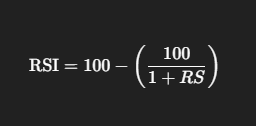

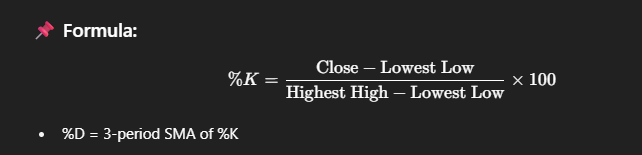

## Technical Analysis

In [13]:
# Technical Analysis
# EMA
df['ema_13'] = df['close'].ewm(span=13, adjust=False).mean()
df['ema_21'] = df['close'].ewm(span=21, adjust=False).mean()

# Stochastic
perc_k_length = 5
perc_k_smoothing = 3
perc_d_length = 3

lowest_low = df['low'].rolling(perc_k_length).min()
highest_high = df['high'].rolling(perc_k_length).max()
df["stochastic_percentage_k"] = ((df['close'] -lowest_low) / (highest_high -lowest_low)).rolling(perc_k_smoothing).mean() 
df["stochastic_percentage_d"] =  df["stochastic_percentage_k"].rolling(perc_d_length).mean()

# MACD
ema_12 = df['close'].ewm(span=12, adjust=False).mean()
ema_26 = df['close'].ewm(span=26, adjust=False).mean()

macd = ema_12 - ema_26
macd_signal_line = macd.ewm(span=9, adjust=False).mean()
macd_bar = macd - macd_signal_line

df['macd'] = macd
df['macd_signal_line'] = macd_signal_line
df['macd_bar'] = macd_bar

## Charting

In [14]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplot with 2 rows (OHLC and Volume)
fig = make_subplots(rows=4, cols=1, 
                    shared_xaxes=True, 
                    vertical_spacing=0.02,
                    row_heights=[0.6, 0.1, 0.15, 0.15],
                    subplot_titles=("OHLC BTC (USD)", "Volume", "Stochastic(5, 3, 3)", "MACD(12, 26, 9)"))

# Plot candlestick
fig.add_trace(go.Candlestick(
    x=df['date'],
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name="Price",
    increasing_line_color='green',
    decreasing_line_color='red'
), row=1, col=1)


# Plot volume bar
fig.add_trace(go.Bar(
    x=df['date'],
    y=df['volume'],
    name="Volume",
    marker_color='orange'
), row=2, col=1)


# Plot EMA
fig.add_trace(
    go.Scatter(
        x=df['date'],
        y=df['ema_13'],
        mode='lines',
        name="EMA 13",
        line={'width': 1.5},
    ), row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=df['date'],
        y=df['ema_21'],
        mode='lines',
        name="EMA 21",
        line={'width': 1.5},
    ), row=1, col=1
)

# Plot Stochastic
fig.add_trace(
    go.Scatter(
        x=df['date'],
        y=df['stochastic_percentage_k'],
        mode='lines',
        name="Stochastic",
        line={'width': 1.5},
    ), row=3, col=1
)

fig.add_trace(
    go.Scatter(
        x=df['date'],
        y=df['stochastic_percentage_d'],
        mode='lines',
        name="Stochastic",
        line={'width': 1.5},
    ), row=3, col=1
)

# Plot MACD
fig.add_trace(
    go.Scatter(
        x=df['date'],
        y=df['macd'],
        mode='lines',
        name="MACD Line",
        line={'width': 1.5},
    ), row=4, col=1
)

fig.add_trace(
    go.Scatter(
        x=df['date'],
        y=df['macd_signal_line'],
        mode='lines',
        name="MACD Signal Line",
        line={'width': 1.5},
    ), row=4, col=1
)

colors = ['green' if val >= 0 else 'red' for val in df['macd_bar']]
fig.add_trace(
    go.Bar(
        x=df['date'], 
        y=df['macd_bar'], 
        name='MACD Bar', 
        marker_color=colors
    ), row=4, col=1
)

# Layout adjustments
fig.update_layout(
    # title=title,
    xaxis_rangeslider_visible=False,
    template='plotly_dark',
    height=1000,
    margin=dict(l=50, r=25, t=50, b=40)
)

fig.show()
fig.write_image(f"btc_{timeframe}_ta.png", width=1200, height=800, scale=2)

# Langchain Anthropic for Analysis

In [6]:
# Create function to convert image to base64
import base64
def get_base64_encoded_image(image_path):
    with open(image_path, "rb") as image_file:
        binary_data = image_file.read()
        base64_encoded_data = base64.b64encode(binary_data)
        base64_string = base64_encoded_data.decode("utf-8")
        return base64_string

image_base64 = get_base64_encoded_image(f"btc_{timeframe}_ta.png")

In [7]:
# Prepare data model for structure data model output
from enum import Enum
from pydantic import BaseModel, Field

class Actions(Enum):
    WEAK_SELL = 'Weak Sell'
    SELL = 'Sell'
    STRONG_SELL = 'Strong Sell'
    WEAK_BUY = 'Weak Buy'
    BUY = 'Buy'
    STRONG_BUY = 'Strong Buy'

class AnalysisResponse(BaseModel):
    actions: Actions = Field(description="Provide actions to take based on the technical analysis")
    reasons: dict[str, str] = Field(description="Provide the technical indicators used as a key and the analysis based on technical indicators as a value")

# Prepare classes for LLM
from langchain_core.prompts import ChatPromptTemplate
from langchain_anthropic import ChatAnthropic
from abc import ABC, abstractmethod

class LLMStrategy(ABC):
    @abstractmethod
    def analyze(self, prompt_template: ChatPromptTemplate, image_base64: str, pair: str, timeframe: str) -> AnalysisResponse:
        pass

class LLMAnalyzerInterface():
    # Define constructore
    
    def __init__(self, llm_strategy: LLMStrategy):
        self.__llm_strategy = llm_strategy
    
    # Define setters and getters
    @property
    def llm_strategy(self):
        return self.__llm_strategy
    
    @llm_strategy.setter
    def set_llm_strateg(self, llm_strategy: LLMStrategy):
        self.__llm_strategy = llm_strategy
    
    # Define abstract method for analysis
    def analyze(self, prompt_template: ChatPromptTemplate, image_base64: str, pair: str, timeframe: str) -> AnalysisResponse:
        return self.llm_strategy.analyze(
            prompt_template=prompt_template,    
            image_base64=image_base64,
            pair=pair, 
            timeframe=timeframe
        )

class AnthropicLLMStrategy(LLMStrategy):
    def __init__(self, **kwargs):
        super().__init__()
        self.__llm = ChatAnthropic(
            **kwargs
        ).with_structured_output(AnalysisResponse)
    
    def analyze(self, prompt_template: ChatPromptTemplate, image_base64: str, pair: str, timeframe: str):
        chain = prompt_template | self.__llm
        return chain.invoke(
        {
            "image_base64": image_base64,
            "pair": pair,
            "timeframe": timeframe,
            "actions" : "\n".join(f"{num+1}. {action.value}" for num, action in enumerate(Actions)),
        }
    )

In [8]:
# Get Anthropic LLM Model
llm_analyzer = LLMAnalyzerInterface(
    AnthropicLLMStrategy(
        model="claude-sonnet-4-20250514",
        max_tokens=20000,
        temperature=0,
        timeout=None,
        max_retries=2
    )
)

# Construct the prompt
from langchain_core.prompts import ChatPromptTemplate
chat_prompt_template = ChatPromptTemplate(
    [
        {
            "role": "system", 
            "content": [
                {
                    "type": "text",
                    "text": "You are a professional cryptocurrency trader at a top proprietary trading firm, specializing in technical analysis."
                }
            ]
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source_type": "base64",
                    "mime_type": "image/png",
                    "data": "{image_base64}",
                },
                {
                    "type": "text",
                    "text": (
                        "Your task is to analyze the {timeframe} chart and technical indicators for {pair} based on the provided image. "
                        "Perform a technical analysis based on candlestick charts, and technical indicators shown in image. "
                        "Your technical analysis should lead to a recommendation one of the following actions:\n"
                        "{actions}"
                    )
                }
            ]
        }
    ],
    input_variables = ["timeframe", "pair", "actions", "image_base64"],
)

chat_prompt_template.format_messages(
    image_base64= image_base64,
    pair= pair,
    timeframe= timeframe,
    actions = "\n".join(f"{num+1}. {action.value}" for num, action in enumerate(Actions)),
    technical_indicators= "EMA, Stochastic, MACD"
)

[SystemMessage(content=[{'type': 'text', 'text': 'You are a professional cryptocurrency trader at a top proprietary trading firm, specializing in technical analysis.'}], additional_kwargs={}, response_metadata={}),
 HumanMessage(content=[{'type': 'image', 'source_type': 'base64', 'mime_type': 'image/png', 'data': 'iVBORw0KGgoAAAANSUhEUgAACWAAAAZACAYAAAD9qXmxAAAAAXNSR0IArs4c6QAAIABJREFUeF7s3Xd0FeXa/vErhCSUhKKigigqgsixYHnP8SiIHkWx0kRApIgCgoCIQKiCFKkiCtJFUBBRpNiOiiigYMFy7BQVFQUFlBYIgZR3zWDiTrKTzG6zZ898s9a7fudn5in3537CX9d6nrjKlSvniB8EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGABeIIYAVsxgAEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAwBQggMVBQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSCFCCAFSQcwxBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABAlicAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgSAECWEHCMQwBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQIIDFGUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEghQg

In [ ]:
response = llm_analyzer.analyze(
    prompt_template = chat_prompt_template,
    image_base64 = image_base64,
    pair = pair,
    timeframe = timeframe,
)

In [ ]:
# Process output
summary = ""
summary += f"Action: **{response.actions.value}**\n"
for num, (indicator, explanation) in enumerate(response.reasons.items()):
    summary += f"**{indicator}**\n{explanation}.\n\n"
summary += "*^Disclaimer Alert.*"

# Send Summary to Discord Channel via Webhook

In [94]:
import requests

webhook_url = "https://discordapp.com/api/webhooks/1387080438140637184/tN2QiS7fsMTOpf9eHQAF8cb2xfAscck9R6qhKq-hvvg4Ssg0YfHsSXvGIDLZUchoFQ6V"
granularity = "Weekly"

embed = {
    "title": f"**Bitcoin (BTC-USD) {granularity.capitalize()} Summary**",
    "image": {"url": "attachment://btc_monthly_ta.png"},
    "description": summary,
    "color": 5814783  # optional: light blue
}
data = {
    "content": (
        f"**Bitcoin (BTC-USD) {granularity.capitalize()} Summary**\n\n"
        f"{summary}"
    )
}


files = {
    "file": (
        "btc_monthly_ta.png", 
        open("C:/Users/USER/projects/ai-agent-crypto-analyzer/notebooks/btc_monthly_ta.png", "rb")
    )
}

# Use `data=` for data when uploading files
requests.post(webhook_url, files=files, data=data)

<Response [200]>